In [2]:
from keras_self_attention import SeqSelfAttention


In [3]:
"""Load packages"""

import numpy as np
from validation import compute_f1
from keras.models import Model, load_model
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D, \
    Flatten, concatenate
from prepro_adjusted import readfile, createBatches, createMatrices, iterate_minibatches, addCharInformation, padding
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
from keras_self_attention import SeqSelfAttention, ScaledDotProductAttention
import string

In [5]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load("../models/pretrained_embeddings")   # load the mat2vec

In [6]:
w2v_model.vector_size

200

In [22]:
from gensim.models import KeyedVectors

#matsci = KeyedVectors.load_word2vec_format("../models/MatSci/fasttext_embeddings-MINIFIED.model")

In [7]:
"""Initialise class"""

class CNN_BLSTM_PUBCHEM(object):
    
    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):
        
        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def loadData(self):
        """Load data and add character information"""
        self.trainSentences = readfile("data/train.txt")
        self.devSentences = readfile("data/dev.txt")
        self.testSentences = readfile("data/test.txt")

    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)

    def embed(self):
        """Create word- and character-level embeddings"""

        labelSet = set()
        words = {}

        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels   
                    labelSet.add(label)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # mapping for token materials
        mat2Idx = {'material': 0, 'other': 1,'PADDING_TOKEN': 2}
        self.matEmbeddings = np.identity(len(mat2Idx), dtype = 'float32')

        # read GLoVE word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        for vocab in w2v_model.wv.vocab:
            word = vocab

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                #vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
                vector = np.zeros(w2v_model.vector_size)
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                #vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
                vector = np.random.uniform(-0.25, 0.25, w2v_model.vector_size)
                self.wordEmbeddings.append(vector)

            #if split[0].lower() in words:
            if word.lower() in words: 
                #vector = np.array([float(num) for num in split[1:]])
                vector = np.array(w2v_model[word])
                self.wordEmbeddings.append(vector)  # word embedding vector
                #word2Idx[split[0]] = len(word2Idx)  # corresponding word dict
                word2Idx[word] = len(word2Idx)

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        # Added code
        characters = string.ascii_letters
        with open('data/train.txt', 'r', encoding = 'utf-8') as infile:
            file = infile.read()
            infile.close()
        tokens = file.split()
        symbols = []
        for word in tokens:
            for ch in word:
                if ch not in characters:
                    symbols.append(ch)
        special_ch = "".join(list(set(symbols)))
        new_characters = characters + special_ch + "¼'\"/\\%$`&=*+@^~|<>\ue0d5∫Å→εζ"
        #for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
        for c in new_characters:
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))

        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels, material = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            material = np.asarray([material])
            pred = model.predict([tokens, casing, char, material], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(
            Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="Character_embedding")(
            character_input)

        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1), name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings],
                          trainable=False)(words_input)

        # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings],
                           trainable=False)(casing_input)
        # Materials info input
        material_input = Input(shape=(None,), dtype='int32', name='material_input')
        material = Embedding(output_dim=self.matEmbeddings.shape[1], input_dim=self.matEmbeddings.shape[0], weights=[self.matEmbeddings], trainable=False)(material_input)
        # concat & BLSTM
        output = concatenate([words, casing, char, material])
        output = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent     # on recurrent input signal
                                   ), name="BLSTM")(output)
        output = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(output)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input, material_input], outputs=[output])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")
        
    def train(self):
        """Default training"""

        self.f1_test_history = []
       
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing, char, material = batch       
                self.model.train_on_batch([tokens, casing, char, material], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
        print("Final Recall test score: ", rec_test)
        print("Final Precision test score: ", pre_test)
            
        print("Training finished.")
            
        # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")

    def writeToFile(self):
        """Write output to file"""

        # .txt file format
        # [epoch  ]
        # [f1_test]
        # [f1_dev ]
        
        output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])

        fileName = self.modelName + ".txt"
        with open(fileName,'wb') as f:
            for line in output:
                np.savetxt(f, line, fmt='%.5f')
                
        print("Model performance written to file.")

    print("Class initialised.")

Class initialised.


In [8]:
"""Set parameters"""

EPOCHS = 50               # paper: 80
DROPOUT = 0.68             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 275     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended


## Run the Model

In [9]:
"""Construct and run model"""

cnn_blstm_pubchem = CNN_BLSTM_PUBCHEM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm_pubchem.loadData()
cnn_blstm_pubchem.addCharInfo()
cnn_blstm_pubchem.embed()
cnn_blstm_pubchem.createBatches()
cnn_blstm_pubchem.buildModel()
cnn_blstm_pubchem.train()
cnn_blstm_pubchem.writeToFile()

ipykernel_launcher:76: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model built. Saved model.png

Epoch 0/50
f1 test  0.3674
f1 dev  0.394 

Epoch 1/50
f1 test  0.616
f1 dev  0.6078 

Epoch 2/50
f1 test  0.6472
f1 dev  0.6404 

Epoch 3/50
f1 test  0.6758
f1 dev  0.6714 

Epoch 4/50
f1 test  0.6725
f1 dev  0.6648 

Epoch 5/50
f1 test  0.6822
f1 dev  0.6874 

Epoch 6/50
f1 test  0.7013
f1 dev  0.7012 

Epoch 7/50
f1 test  0.655
f1 dev  0.6606 

Epoch 8/50
f1 test  0.6925
f1 dev  0.7038 

Epoch 9/50
f1 test  0.6934
f1 dev  0.6982 

Epoch 10/50
f1 test  0.7193
f1 dev  0.7314 

Epoch 11/50
f1 test  0.7056
f1 dev  0.7056 

Epoch 12/50
f1 test  0.7021
f1 dev  0.7154 

Epoch 13/50
f1 test  0.7117
f1 dev  0.7213 

Epoch 14/50
f1 test  0.7201
f1 dev  0.7363 

Epoch 15/50
f1 test  0.7079
f1 dev  0.7282 

Epoch 16/50
f1 test  0.7121
f1 dev  0.7226 

Epoch 17/50
f1 test  0.7135
f1 dev  0.7241 

Epoch 18/50
f1 test  0.7114
f1 dev  0.7327 

Epoch 19/50
f1 test  0.7076
f1 dev  0.7088 

Epoch 20/50
f1 test  0.7259
f1 dev  0.7365 

Epoch 21/50
f1 test  0.7317
f1 dev  0.

# Plot learning curve

In [10]:
import matplotlib.pyplot as plt

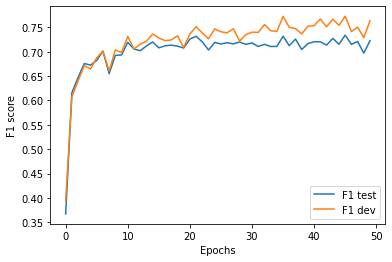

In [11]:
plt.plot(cnn_blstm_pubchem.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm_pubchem.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

# Label distribution

In [12]:
cnn_blstm_pubchem = CNN_BLSTM_PUBCHEM(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm_pubchem.loadData()

category_count = {"B-Material\n": 0, "I-Material\n":0, "B-Property\n": 0, "I-Property\n":0, "B-Value\n": 0, "I-Value\n": 0, "B-Condition\n": 0, "I-Condition\n": 0, "O\n": 0}
total_count = 0

for sentence in cnn_blstm_pubchem.trainSentences:
    for word in sentence:
        if word[1] in category_count.keys():
            category_count[word[1]] += 1
            total_count += 1

for category, count in category_count.items():
    print("{}: {}%".format(category.replace("\n", ""), round((count/total_count)*100, 2)))            

B-Material: 1.92%
I-Material: 2.78%
B-Property: 2.13%
I-Property: 2.77%
B-Value: 1.05%
I-Value: 2.1%
B-Condition: 0.58%
I-Condition: 0.62%
O: 86.05%


## Adding Attention layers to the architecture

In [13]:
"""Initialise class"""

class CNN_BLSTM_PUBCHEM_ATTN(object):

    def __init__(self, EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER):

        self.epochs = EPOCHS
        self.dropout = DROPOUT
        self.dropout_recurrent = DROPOUT_RECURRENT
        self.lstm_state_size = LSTM_STATE_SIZE
        self.conv_size = CONV_SIZE
        self.learning_rate = LEARNING_RATE
        self.optimizer = OPTIMIZER
        
    def loadData(self):
        """Load data and add character information"""
        self.trainSentences = readfile("data/train.txt")
        self.devSentences = readfile("data/dev.txt")
        self.testSentences = readfile("data/test.txt")

    def addCharInfo(self):
        # format: [['EU', ['E', 'U'], 'B-ORG\n'], ...]
        self.trainSentences = addCharInformation(self.trainSentences)
        self.devSentences = addCharInformation(self.devSentences)
        self.testSentences = addCharInformation(self.testSentences)
    
    def embed(self):
        """Create word- and character-level embeddings"""
        
        labelSet = set()
        words = {}

        # unique words and labels in data  
        for dataset in [self.trainSentences, self.devSentences, self.testSentences]:
            for sentence in dataset:
                for token, char, label in sentence:
                    # token ... token, char ... list of chars, label ... BIO labels   
                    labelSet.add(label)
                    words[token.lower()] = True

        # mapping for labels
        self.label2Idx = {}
        for label in labelSet:
            self.label2Idx[label] = len(self.label2Idx)

        # mapping for token cases
        case2Idx = {'numeric': 0, 'allLower': 1, 'allUpper': 2, 'initialUpper': 3, 'other': 4, 'mainly_numeric': 5,
                    'contains_digit': 6, 'PADDING_TOKEN': 7}
        self.caseEmbeddings = np.identity(len(case2Idx), dtype='float32')  # identity matrix used 

        # mapping for token materials
        mat2Idx = {'material': 0, 'other': 1,'PADDING_TOKEN': 2}
        self.matEmbeddings = np.identity(len(mat2Idx), dtype = 'float32')

        # read mat2vec word embeddings
        word2Idx = {}
        self.wordEmbeddings = []

        for vocab in w2v_model.wv.vocab:
            word = vocab

            if len(word2Idx) == 0:  # add padding+unknown
                word2Idx["PADDING_TOKEN"] = len(word2Idx)
                vector = np.zeros(w2v_model.vector_size) # zero vector for 'PADDING' word
                self.wordEmbeddings.append(vector)

                word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
                vector = np.random.uniform(-0.25, 0.25, w2v_model.vector_size)
                self.wordEmbeddings.append(vector)

            if word.lower() in words: 
                vector = np.array(w2v_model[word])
                self.wordEmbeddings.append(vector)  # word embedding vector
                #word2Idx[split[0]] = len(word2Idx)  # corresponding word dict
                word2Idx[word] = len(word2Idx)

        self.wordEmbeddings = np.array(self.wordEmbeddings)

        # dictionary of all possible characters
        self.char2Idx = {"PADDING": 0, "UNKNOWN": 1}
        # Added code
        characters = string.ascii_letters
        with open('data/train.txt', 'r', encoding = 'utf-8') as infile:
            file = infile.read()
            infile.close()
        tokens = file.split()
        symbols = []
        for word in tokens:
            for ch in word:
                if ch not in characters:
                    symbols.append(ch)
        special_ch = "".join(list(set(symbols)))
        new_characters = characters + special_ch + "¼'\"/\\%$`&=*+@^~|<>\ue0d5∫Å→εζ"
        for c in new_characters:
            self.char2Idx[c] = len(self.char2Idx)

        # format: [[wordindices], [caseindices], [padded word indices], [label indices]]
        self.train_set = padding(createMatrices(self.trainSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))
        self.dev_set = padding(createMatrices(self.devSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))
        self.test_set = padding(createMatrices(self.testSentences, word2Idx, self.label2Idx, case2Idx, self.char2Idx, mat2Idx))

        self.idx2Label = {v: k for k, v in self.label2Idx.items()}
        
    def createBatches(self):
        """Create batches"""
        self.train_batch, self.train_batch_len = createBatches(self.train_set)
        self.dev_batch, self.dev_batch_len = createBatches(self.dev_set)
        self.test_batch, self.test_batch_len = createBatches(self.test_set)
        
    def tag_dataset(self, dataset, model):
        """Tag data with numerical values"""
        correctLabels = []
        predLabels = []
        for i, data in enumerate(dataset):
            tokens, casing, char, labels, material = data
            tokens = np.asarray([tokens])
            casing = np.asarray([casing])
            char = np.asarray([char])
            material = np.asarray([material])
            pred = model.predict([tokens, casing, char, material], verbose=False)[0]
            pred = pred.argmax(axis=-1)  # Predict the classes
            correctLabels.append(labels)
            predLabels.append(pred)
        return predLabels, correctLabels
    
    def buildModel(self):
        """Model layers"""

        # character input
        character_input = Input(shape=(None, 52,), name="Character_input")
        embed_char_out = TimeDistributed(Embedding(len(self.char2Idx), 30, embeddings_initializer=RandomUniform(minval=-0.5,
        maxval=0.5)), name="Character_embedding")(character_input)
            
        dropout = Dropout(self.dropout)(embed_char_out)

        # CNN
        conv1d_out = TimeDistributed(Conv1D(kernel_size=self.conv_size, filters=30, padding='same', activation='tanh', strides=1),   name="Convolution")(dropout)
        maxpool_out = TimeDistributed(MaxPooling1D(52), name="Maxpool")(conv1d_out)
        char = TimeDistributed(Flatten(), name="Flatten")(maxpool_out)
        char = Dropout(self.dropout)(char)

        # word-level input
        words_input = Input(shape=(None,), dtype='int32', name='words_input')
        words = Embedding(input_dim=self.wordEmbeddings.shape[0], output_dim=self.wordEmbeddings.shape[1], weights=[self.wordEmbeddings], trainable=False)(words_input)

         # case-info input
        casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
        casing = Embedding(output_dim=self.caseEmbeddings.shape[1], input_dim=self.caseEmbeddings.shape[0], weights=[self.caseEmbeddings], trainable=False)(casing_input)

        # Materials info input
        material_input = Input(shape=(None,), dtype='int32', name='material_input')
        material = Embedding(output_dim=self.matEmbeddings.shape[1], input_dim=self.matEmbeddings.shape[0], weights=[self.matEmbeddings], trainable=False)(material_input)
        # concat & BLSTM
        output = concatenate([words, casing, char, material])
        lstm = Bidirectional(LSTM(self.lstm_state_size, 
                                    return_sequences=True, 
                                    dropout=self.dropout,                        # on input to each LSTM block
                                    recurrent_dropout=self.dropout_recurrent),     # on recurrent input signal
                                   name="BLSTM")(output)
        # Pay attention 
        att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                       kernel_regularizer=keras.regularizers.l2(1e-4),
                       bias_regularizer=keras.regularizers.l1(1e-4),
                       attention_regularizer_weight=1e-4)(lstm)
        #dense = Dense(len(self.label2Idx), activation = 'softmax', name = "Softmax_layer")(att)
        dense = TimeDistributed(Dense(len(self.label2Idx), activation='softmax'),name="Softmax_layer")(att)

        # set up model
        self.model = Model(inputs=[words_input, casing_input, character_input, material_input], outputs=[dense])
        
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=self.optimizer)
        
        self.init_weights = self.model.get_weights()
        
        plot_model(self.model, to_file='model.png')
        
        print("Model built. Saved model.png\n")

    def train(self):
        """Default training"""

        self.f1_test_history = []
        self.f1_dev_history = []

        for epoch in range(self.epochs):    
            print("Epoch {}/{}".format(epoch, self.epochs))
            for i,batch in enumerate(iterate_minibatches(self.train_batch,self.train_batch_len)):
                labels, tokens, casing, char, material = batch       
                self.model.train_on_batch([tokens, casing, char, material], labels)

            # compute F1 scores
            predLabels, correctLabels = self.tag_dataset(self.test_batch, self.model)
            pre_test, rec_test, f1_test = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_test_history.append(f1_test)
            print("f1 test ", round(f1_test, 4))

            predLabels, correctLabels = self.tag_dataset(self.dev_batch, self.model)
            pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, self.idx2Label)
            self.f1_dev_history.append(f1_dev)
            print("f1 dev ", round(f1_dev, 4), "\n")
            
        print("Final F1 test score: ", f1_test)
        print("Final Recall test score: ", rec_test)
        print("Final Precision test score: ", pre_test)
            
        print("Training finished.")
         # save model
        self.modelName = "{}_{}_{}_{}_{}_{}_{}".format(self.epochs, 
                                                        self.dropout, 
                                                        self.dropout_recurrent, 
                                                        self.lstm_state_size,
                                                        self.conv_size,
                                                        self.learning_rate,
                                                        self.optimizer.__class__.__name__
                                                       )
        
        modelName = self.modelName + ".h5"
        self.model.save(modelName)
        print("Model weights saved.")
        
        self.model.set_weights(self.init_weights)  # clear model
        print("Model weights cleared.")

    def writeToFile(self):
        """Write output to file"""

        output = np.matrix([[int(i) for i in range(self.epochs)], self.f1_test_history, self.f1_dev_history])
        fileName = self.modelName + ".txt"
        with open(fileName,'wb') as f:
            for line in output:
                np.savetxt(f, line, fmt='%.5f')
                
        print("Model performance written to file.")

    print("Class initialised.")




Class initialised.


## Set the parameters

In [14]:
"""Set parameters"""
EPOCHS = 50               # paper: 80
DROPOUT = 0.68             # paper: 0.68
DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
LSTM_STATE_SIZE = 275     # paper: 275
CONV_SIZE = 3             # paper: 3
LEARNING_RATE = 0.0105    # paper 0.0105
OPTIMIZER = Nadam()       # paper uses SGD(lr=self.learning_rate), Nadam() recommended


## Run the Adjusted Model

In [15]:
import keras

In [16]:
"""Construct and run model"""

cnn_blstm_pubchem_attn = CNN_BLSTM_PUBCHEM_ATTN(EPOCHS, DROPOUT, DROPOUT_RECURRENT, LSTM_STATE_SIZE, CONV_SIZE, LEARNING_RATE, OPTIMIZER)
cnn_blstm_pubchem_attn.loadData()
cnn_blstm_pubchem_attn.addCharInfo()
cnn_blstm_pubchem_attn.embed()
cnn_blstm_pubchem_attn.createBatches()
cnn_blstm_pubchem_attn.buildModel()
cnn_blstm_pubchem_attn.train()
cnn_blstm_pubchem_attn.writeToFile()

ipykernel_launcher:72: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Model built. Saved model.png

Epoch 0/50
f1 test  0
f1 dev  0 

Epoch 1/50
f1 test  0.0538
f1 dev  0.043 

Epoch 2/50
f1 test  0.1172
f1 dev  0.096 

Epoch 3/50
f1 test  0.0902
f1 dev  0.1021 

Epoch 4/50
f1 test  0.325
f1 dev  0.3336 

Epoch 5/50
f1 test  0.4199
f1 dev  0.4703 

Epoch 6/50
f1 test  0.6004
f1 dev  0.5707 

Epoch 7/50
f1 test  0.6075
f1 dev  0.5722 

Epoch 8/50
f1 test  0.6396
f1 dev  0.6258 

Epoch 9/50
f1 test  0.6372
f1 dev  0.6245 

Epoch 10/50
f1 test  0.6706
f1 dev  0.6546 

Epoch 11/50
f1 test  0.6411
f1 dev  0.6396 

Epoch 12/50
f1 test  0.6825
f1 dev  0.694 

Epoch 13/50
f1 test  0.6741
f1 dev  0.6656 

Epoch 14/50
f1 test  0.6531
f1 dev  0.6528 

Epoch 15/50
f1 test  0.6757
f1 dev  0.6833 

Epoch 16/50
f1 test  0.6521
f1 dev  0.656 

Epoch 17/50
f1 test  0.6752
f1 dev  0.6764 

Epoch 18/50
f1 test  0.6798
f1 dev  0.6861 

Epoch 19/50
f1 test  0.631
f1 dev  0.6368 

Epoch 20/50
f1 test  0.6545
f1 dev  0.666 

Epoch 21/50
f1 test  0.6654
f1 dev  0.6791 

Epoch 2

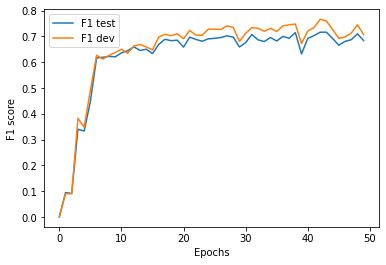

In [15]:
import matplotlib.pyplot as plt 
plt.plot(cnn_blstm_pubchem_attn.f1_test_history, label = "F1 test")
plt.plot(cnn_blstm_pubchem_attn.f1_dev_history, label = "F1 dev")
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [16]:
plt.savefig("mat2vec_pubchem_attn.png")

<Figure size 432x288 with 0 Axes>